# IBM Data Science Cap Stone Project Final Report

## In this notebook, I will be creating clusters to find the most suitable location for senior citizens to live in Toronto, Canada.

In [2]:
import requests
import pandas as pd

In [3]:
#scrapping neighborhoods in Canada
url  = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
page = requests.get(url)
if page.status_code == 200:
    print('Page download successful')
else:
    print('Page download error. Error code: {}'.format(page.status_code))

Page download successful


In [4]:
df_html = pd.read_html(url, header=0, na_values = ['Not assigned'])[0]
df_html.head()

,Postal Code,Borough,Neighborhood
0,M1A,NaN,NaN
1,M2A,NaN,NaN
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [5]:
#Drop the the rows on which the Borough is empty
df_html.dropna(subset=['Borough'], inplace=True)

In [6]:
#Check Neighborhood is empty but Borough exists
n_empty_neighborhood = df_html[df_html['Neighborhood'].isna()].shape[0]
print('Number of rows on which Neighborhood column is empty: {}'.format(n_empty_neighborhood))

Number of rows on which Neighborhood column is empty: 0


In [7]:
#Group by Postcode / Borough
df_postcodes = df_html.groupby(['Postal Code','Borough']).Neighborhood.agg([('Neighborhood', ', '.join)])
df_postcodes.reset_index(inplace=True)
df_postcodes.head(5)

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [8]:
print('The shape of the dataset is:',df_postcodes.shape)

The shape of the dataset is: (103, 3)


In [9]:
import numpy as np

Extracting the latitude and longitude from the csv file.

In [10]:
#Read CSV file from link and load into dataframe
url_csv = 'http://cocl.us/Geospatial_data'
df_coordinates = pd.read_csv(url_csv)
df_coordinates.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [11]:
df_neighborhoods = df_postcodes

In [12]:
df_neighborhoods.head()

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [13]:
# Make sure both dataframes have the same 
df_coordinates.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)
df_neighborhoods.rename(columns={'Postal Code': 'PostalCode'}, inplace=True)

In [14]:
# Merge both datasets
df_neighborhoods_coordinates = pd.merge(df_neighborhoods, df_coordinates, on='PostalCode')
df_neighborhoods_coordinates.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [15]:
df=df_neighborhoods_coordinates

In [16]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(df['Borough'].unique()),
        df.shape[0]
    )
)

The dataframe has 10 boroughs and 103 neighborhoods.


In [17]:
#count Bourough and Neighborhood
df.groupby('Borough').count()['Neighborhood']


Borough
Central Toronto      9
Downtown Toronto    19
East Toronto         5
East York            5
Etobicoke           12
Mississauga          1
North York          24
Scarborough         17
West Toronto         6
York                 5
Name: Neighborhood, dtype: int64

In [18]:
#Obtain the coordinates from the dataset itself, just averaging Latitude/Longitude of the current dataset 
lat_toronto = df['Latitude'].mean()
lon_toronto = df['Longitude'].mean()
print('The geographical coordinates of Toronto are {}, {}'.format(lat_toronto, lon_toronto))

The geographical coordinates of Toronto are 43.70460773398059, -79.39715291165048


In [19]:
CLIENT_ID = '5UQSCPUWNKXXDYJVNKKOLLGBEACBGOZR10LZ4ZGDM2CHNYUM' # your Foursquare ID
CLIENT_SECRET = 'LEMR0XVA0XIMQIKPI0GWVIH1X1JHZOF0XFVDPEVKR0TSAIDM' # your Foursquare Secret
VERSION = '20180605'
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
#Get venues for all neighborhoods in our dataset
toronto_venues = getNearbyVenues(names=df['Neighborhood'],
                                latitudes=df['Latitude'],
                                longitudes=df['Longitude'])


Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale
York Mills West
Willowdale
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence P

In [22]:

#Check size of resulting dataframe
toronto_venues.shape


(2108, 7)

In [23]:
toronto_venues.head()


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Chris Effects Painting,43.784343,-79.163742,Construction & Landscaping
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


In [24]:
#Number of venues per neighborhood
toronto_venues.groupby('Neighborhood').count()


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,5,5,5,5,5,5
"Alderwood, Long Branch",9,9,9,9,9,9
"Bathurst Manor, Wilson Heights, Downsview North",20,20,20,20,20,20
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",23,23,23,23,23,23
...,...,...,...,...,...,...
"Wexford, Maryvale",4,4,4,4,4,4
Willowdale,38,38,38,38,38,38
Woburn,3,3,3,3,3,3


In [25]:
#Number of unique venue categories
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 262 uniques categories.


In [26]:
#print out the list of categories
toronto_venues['Venue Category'].unique()[:100]

array(['Fast Food Restaurant', 'Construction & Landscaping', 'Bar',
       'Bank', 'Electronics Store', 'Mexican Restaurant',
       'Rental Car Location', 'Medical Center', 'Intersection',
       'Breakfast Spot', 'Coffee Shop', 'Korean Restaurant',
       'Hakka Restaurant', 'Caribbean Restaurant', 'Thai Restaurant',
       'Athletics & Sports', 'Bakery', 'Gas Station', 'Lounge',
       'Fried Chicken Joint', 'Playground', 'Department Store',
       'Convenience Store', 'Discount Store', 'Chinese Restaurant',
       'Bus Station', 'Ice Cream Shop', 'Metro Station', 'Bus Line',
       'Park', 'Soccer Field', 'Motel', 'American Restaurant', 'Café',
       'General Entertainment', 'Skating Rink', 'College Stadium',
       'Indian Restaurant', 'Vietnamese Restaurant', 'Pet Store',
       'Smoke Shop', 'Middle Eastern Restaurant',
       'Latin American Restaurant', 'Clothing Store',
       'Italian Restaurant', 'Noodle House', 'Pizza Place', 'Pharmacy',
       'Grocery Store', 'Sandwich 

# These categories are considered as requirements for senior citizens in their neigborhoods: pharmacy, park, grocery store, medical center, bank.

In [166]:
# check if the results contain "Thai Restaurants"
#please note I changed the data to Thai because I was previously writing the code using Asian but the number is so small
"Bank" in toronto_venues['Venue Category'].unique()

True

In [167]:
"Pharmacy" in toronto_venues['Venue Category'].unique()

True

In [168]:
"Park" in toronto_venues['Venue Category'].unique()

True

In [169]:
"Grocery Store" in toronto_venues['Venue Category'].unique()

True

### Analyze Each Neighborhood

In [239]:
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

(2108, 263)


,Neighborhoods,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Rouge Hill, Port Union, Highland Creek",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Rouge Hill, Port Union, Highland Creek",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [240]:
new=to_onehot.loc[(to_onehot["Park"] ==1) | (to_onehot["Grocery Store"]==1) | (to_onehot["Bank"]==1) | (to_onehot["Pharmacy"]==1)]

In [241]:
new.shape

(124, 263)

In [242]:
to_grouped = new.groupby(["Neighborhoods"]).max().reset_index()

print(to_grouped.shape)
to_grouped

(60, 263)


,Neighborhoods,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Alderwood, Long Branch",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Bathurst Manor, Wilson Heights, Downsview North",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Bayview Village,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Bedford Park, Lawrence Manor East",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Berczy Park,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"Brockton, Parkdale Village, Exhibition Place",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,Business reply mail Processing Centre,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Caledonia-Fairbanks,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,Cedarbrae,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Central Bay Street,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Create a new dataframe to find Hospital, Pharmacy, Medical Center, Department Store, Grocery Store and Park only.

In [243]:
older = to_grouped[["Neighborhoods","Bank","Pharmacy","Grocery Store","Park"]]

In [244]:
older.head()

,Neighborhoods,Bank,Pharmacy,Grocery Store,Park
0,"Alderwood, Long Branch",0,1,0,0
1,"Bathurst Manor, Wilson Heights, Downsview North",1,1,0,0
2,Bayview Village,1,0,0,0
3,"Bedford Park, Lawrence Manor East",0,1,1,0
4,Berczy Park,0,0,1,1


# Cluster Neighborhoods

### Run k-means to cluster the neighborhoods in Toronto into 3 clusters.

In [245]:
x=older.iloc[:,[1,2,3,4]]
x.shape

(60, 4)

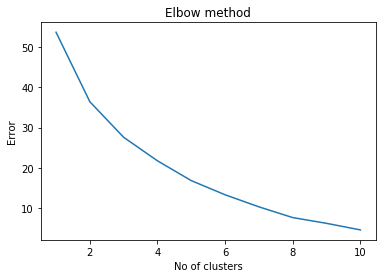

In [246]:
from sklearn.cluster import KMeans
Error =[]
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i).fit(x)
    kmeans.fit(x)
    Error.append(kmeans.inertia_)
import matplotlib.pyplot as plt
plt.plot(range(1, 11), Error)
plt.title('Elbow method')
plt.xlabel('No of clusters')
plt.ylabel('Error')
plt.show()

In [247]:
kmeans=KMeans(n_clusters=3).fit(x)
labels=kmeans.predict(x)
print(labels)

[0 1 1 0 0 0 2 2 1 2 0 0 1 2 2 2 0 0 2 1 2 1 2 2 1 1 0 2 0 2 0 2 2 0 2 0 2
 2 1 2 1 1 2 0 0 0 0 0 0 1 1 2 0 0 1 1 2 0 2 1]


In [248]:
older['Cluster Labels']=labels

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [249]:
older.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [250]:
to_merged = older.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

(1740, 12)


,Neighborhood,Bank,Pharmacy,Grocery Store,Park,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Alderwood, Long Branch",0,1,0,0,0,43.602414,-79.543484,Il Paesano Pizzeria & Restaurant,43.601280,-79.545028,Pizza Place
0,"Alderwood, Long Branch",0,1,0,0,0,43.602414,-79.543484,Timothy's Pub,43.600165,-79.544699,Pub
0,"Alderwood, Long Branch",0,1,0,0,0,43.602414,-79.543484,Toronto Gymnastics International,43.599832,-79.542924,Gym
0,"Alderwood, Long Branch",0,1,0,0,0,43.602414,-79.543484,Tim Hortons,43.602396,-79.545048,Coffee Shop
0,"Alderwood, Long Branch",0,1,0,0,0,43.602414,-79.543484,Pizza Pizza,43.605340,-79.547252,Pizza Place


In [251]:
# sort the results by Cluster Labels
print(to_merged.shape)
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged

(1740, 12)


,Neighborhood,Bank,Pharmacy,Grocery Store,Park,Cluster Labels,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Alderwood, Long Branch",0,1,0,0,0,43.602414,-79.543484,Il Paesano Pizzeria & Restaurant,43.601280,-79.545028,Pizza Place
43,"Runnymede, Swansea",1,0,1,1,0,43.651571,-79.484450,Classico,43.649194,-79.484699,Pizza Place
43,"Runnymede, Swansea",1,0,1,1,0,43.651571,-79.484450,My Place - a Canadian Pub,43.648458,-79.485187,Pub
43,"Runnymede, Swansea",1,0,1,1,0,43.651571,-79.484450,Yama,43.649857,-79.482052,Sushi Restaurant
43,"Runnymede, Swansea",1,0,1,1,0,43.651571,-79.484450,(The New) Moksha Yoga Bloor West,43.648658,-79.485242,Yoga Studio
...,...,...,...,...,...,...,...,...,...,...,...,...
14,Davisville,0,1,0,1,2,43.704324,-79.388790,Granite Brewery,43.707991,-79.389943,Brewery
14,Davisville,0,1,0,1,2,43.704324,-79.388790,Hazel's Diner,43.702103,-79.387618,Diner
14,Davisville,0,1,0,1,2,43.704324,-79.388790,souvlaki express,43.707378,-79.389848,Greek Restaurant
51,"The Annex, North Midtown, Yorkville",0,1,0,1,2,43.672710,-79.405678,Madame Boeuf And Flea,43.675240,-79.406620,Burger Joint


In [257]:
newdf=to_merged.iloc[:,[0,1,2,3,4,5]]

In [258]:
newdf = newdf.groupby(["Neighborhood"]).max().reset_index()

print(newdf.shape)
newdf

(60, 6)


,Neighborhood,Bank,Pharmacy,Grocery Store,Park,Cluster Labels
0,"Alderwood, Long Branch",0,1,0,0,0
1,"Bathurst Manor, Wilson Heights, Downsview North",1,1,0,0,1
2,Bayview Village,1,0,0,0,1
3,"Bedford Park, Lawrence Manor East",0,1,1,0,0
4,Berczy Park,0,0,1,1,0
5,"Brockton, Parkdale Village, Exhibition Place",0,0,1,0,0
6,Business reply mail Processing Centre,0,0,0,1,2
7,Caledonia-Fairbanks,0,0,0,1,2
8,Cedarbrae,1,0,0,0,1
9,Central Bay Street,0,0,0,1,2


In [259]:
#Cluster 0
newdf.loc[newdf['Cluster Labels'] == 0]

,Neighborhood,Bank,Pharmacy,Grocery Store,Park,Cluster Labels
0,"Alderwood, Long Branch",0,1,0,0,0
3,"Bedford Park, Lawrence Manor East",0,1,1,0,0
4,Berczy Park,0,0,1,1,0
5,"Brockton, Parkdale Village, Exhibition Place",0,0,1,0,0
10,Christie,0,0,1,1,0
11,Church and Wellesley,0,0,1,1,0
16,Downsview,1,0,1,1,0
17,"Dufferin, Dovercourt Village",1,1,1,1,0
26,"High Park, The Junction South",0,0,1,1,0
28,"Kensington Market, Chinatown, Grange Park",0,1,1,1,0


In [260]:
newdf.loc[newdf['Cluster Labels'] == 1]

,Neighborhood,Bank,Pharmacy,Grocery Store,Park,Cluster Labels
1,"Bathurst Manor, Wilson Heights, Downsview North",1,1,0,0,1
2,Bayview Village,1,0,0,0,1
8,Cedarbrae,1,0,0,0,1
12,"Clarks Corners, Tam O'Shanter, Sullivan",1,1,0,0,1
19,"Fairview, Henry Farm, Oriole",1,1,0,0,1
21,"Garden District, Ryerson",1,0,0,1,1
24,"Guildwood, Morningside, West Hill",1,0,0,0,1
25,"Harbourfront East, Union Station, Toronto Islands",1,0,0,1,1
38,"Parkview Hill, Woodbine Gardens",1,1,0,0,1
40,"Queen's Park, Ontario Provincial Government",1,0,0,1,1


In [261]:
newdf.loc[newdf['Cluster Labels'] == 2]

,Neighborhood,Bank,Pharmacy,Grocery Store,Park,Cluster Labels
6,Business reply mail Processing Centre,0,0,0,1,2
7,Caledonia-Fairbanks,0,0,0,1,2
9,Central Bay Street,0,0,0,1,2
13,"Commerce Court, Victoria Hotel",0,0,0,1,2
14,Davisville,0,1,0,1,2
15,Davisville North,0,0,0,1,2
18,East Toronto,0,0,0,1,2
20,Forest Hill North & West,0,0,0,1,2
22,Glencairn,0,0,0,1,2
23,"Golden Mile, Clairlea, Oakridge",0,0,0,1,2


# Visualize the Clusters

In [263]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

In [268]:
map_clusters = folium.Map(location=[lat_toronto, lon_toronto], zoom_start=11)

# set color scheme for the clusters
toclusters=3
x = np.arange(toclusters)
ys = [i+x+(i*x)**2 for i in range(toclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Neighborhood'], to_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster),parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill_color=rainbow[cluster-1],
        label=to_merged.iloc[i]["Cluster Labels"],
        fill_opacity=0.7, parse_html=False).add_to(map_clusters)
       
map_clusters

# Observations

Most of the requirements for senior citizens are met in Cluster 0 which has 22 Neighborhoods. All the neighborhoods(16) in Cluster 1 has Bank and all the neighborhoods(22) in Cluster 2 has Parks. Looking at nearby venues, it seems Cluster 0 might be a good location as most of the requirements are met in these neighborhoods. Therefore, this project recommends the neighborhoods suitable for the senior citizens to live in Toronto.